In [1]:
import numpy as np
import tensorflow as tf
import os
import json
import glob
import tqdm.notebook as tqdm
import sklearn.metrics
import sklearn.model_selection
import tensorflow_addons as tfa
from gensim.models import Word2Vec, FastText

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
def read(path: str):
    balanced_labels = [
        'dp',
        'greedy',
        'implementation',
        'dfs and similar',
        'graphs',
        'brute force',
        'math',
        'number theory',
        'constructive algorithms',
        'trees',
        'binary search',
        'data structures',
        'two pointers',
        '*special',
        'sortings',
        'strings',
        'bitmasks',
        'combinatorics',
        'geometry',
    ]
    codes = []
    tags = []
    paths = []
    for i in tqdm.tqdm(glob.iglob(os.path.join(path, '*.json')), desc='Reading data', total=(len(os.listdir(path)) - 1) // 2):
        pre, ext = os.path.splitext(i)
        tags.append(list(filter(lambda tag: tag in balanced_labels, json.load(open(i, 'r', encoding='utf-8'))['Tags'])))
        statements = open(pre + '.java.ast.stm.flat', 'r', encoding='utf-8').read().strip('\n').split('\n\n')
        codes.append([])
        paths.append(i)
        for stm in statements:
            if len(stm) > 200:
                continue
            codes[-1].append([])
            for line in stm.split('\n'):
                try:
                    token, children = line.split('\t')
                    children = tuple(map(int, children.split())) if children else ()
                    codes[-1][-1].append((token, children))
                except Exception as e:
                    print(i)
                    print(line)
                    print()
                    print(stm)
                    raise e

    # validate
    for code, p in zip(codes, paths):
        for statement in code:
            for node, children in statement:
                for child in children:
                    try:
                        _ = statement[child]
                    except Exception as e:
                        print(p)
                        print(node)
                        print(child)
                        print(statement)
                        raise e

    return codes, tags, paths

In [3]:
codes, tags, paths = read(f'../data/revisited/java/full')

Reading data:   0%|          | 0/48537 [00:00<?, ?it/s]

In [4]:
class StatementTreeDataset(tf.keras.utils.Sequence):
    def __init__(self, vectorized, indices, he_tags, batch_size):
        self.vectorized = vectorized
        self.indices = indices
        self.he_tags = he_tags
        self.batch_size = batch_size
        self.shuffle()

    def __len__(self):
        return (len(self.vectorized) + self.batch_size - 1) // self.batch_size

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
        vectorized_batch = self.vectorized[start:end]
        indices_batch = self.indices[start:end]
        he_tags_batch = self.he_tags[start:end]

        max_len = max(len(j) for i in vectorized_batch for j in i)
        code_batch = tf.keras.preprocessing.sequence.pad_sequences(
            [tf.keras.preprocessing.sequence.pad_sequences(i, padding='post', maxlen=max_len) for i in vectorized_batch],
            padding='post'
        )
        code_batch = code_batch[:,1:129]
        indices_batch = [[i[j] for j in range(1, min(129, len(i)))] for i in indices_batch]
        return (code_batch, indices_batch), he_tags_batch

    def shuffle(self):
        indices = np.arange(len(self.vectorized))
        np.random.shuffle(indices)

        self.vectorized = [self.vectorized[i] for i in indices]
        self.indices = [self.indices[i] for i in indices]
        self.he_tags = [self.he_tags[i] for i in indices]

    def on_epoch_end(self):
        self.shuffle()

In [49]:
class StatementTreeModel:
    def __init__(self, codes, tags, name: str = 'STM'):
        self.name = name
        self.epochs = 0
        self.embedding_layer = None
        self.embedding_encoder = None
        self.tree_encoder = None
        self.optimizer = None

        vocab = set()
        for code in codes:
            for statement in code:
                for token, _ in statement:
                    vocab.add(token)
        self.__vocab = list(vocab)
        self.__token_to_id = {j:i for i, j in enumerate(vocab)}

        labels = set()
        for tag_list in tags:
            for tag in tag_list:
                labels.add(tag)
        self.__labels = list(labels)
        self.__label_to_id = {label: i for i, label in enumerate(labels)}

        vectorized, indices, he_tags = [], [], []

        # vectorize code, split tokens and children indices
        for code in codes:
            vectorized.append([])
            indices.append([])
            for statement in code:
                vectorized[-1].append([])
                indices[-1].append([])
                for token, _ in statement:
                    vectorized[-1][-1].append(self.__token_to_id[token] + 1)
                    indices[-1][-1].append(_)

        # labels hot-encoding
        for tag_list in tags:
            he_tags.append([0] * len(labels))
            for tag in tag_list:
                he_tags[-1][self.__label_to_id[tag]] = 1

        # split data
        self.__vectorized_train, self.__vectorized_test, \
        self.__indices_train, self.__indices_test, \
        self.__he_tags_train, self.__he_tags_test = \
            sklearn.model_selection.train_test_split(vectorized,
                                                     indices,
                                                     he_tags)

        # load embeddings
        self.__vocab_shift = 1
        self.__embedding_input_size = len(vocab) + self.__vocab_shift
        self.__embedding_output_size = 192
        self.__embedding_encoder_output_size = 128
        self.__embeddings = {'w2v': Word2Vec, 'ft': FastText}
        for emb in self.__embeddings.keys():
            model = self.__embeddings[emb].load(f'../embeddings/revisited/java/full/stm.{emb}')
            wv = model.wv
            self.__embeddings[emb] = np.array([wv[i] if i in wv else np.zeros((self.__embedding_output_size,)) for i in vocab])

    def __create_embedding_layer(self, pre_trained = None):
        embedding = tf.keras.layers.Embedding(self.__embedding_input_size, self.__embedding_output_size,
                                              name='Tree_Embedding', mask_zero=True)
        embedding.build((None, None, None))
        embedding.trainable = pre_trained is None
        if pre_trained is not None:
            weights = np.zeros((self.__embedding_input_size, self.__embedding_output_size))
            for i, token in enumerate(self.__vocab):
                try:
                    weights[i + self.__vocab_shift] = pre_trained[i]
                except:
                    pass
            embedding.set_weights([weights])
        return embedding

    def __create_embedding_encoder(self):
        inputs = tf.keras.layers.Input((None, None, self.__embedding_output_size))
        outputs = tf.keras.layers.Dense(self.__embedding_encoder_output_size)(inputs)
        return tf.keras.Model(inputs=inputs, outputs=outputs, name='Embedding_Encoder')

    def __create_tree_encoder(self, backbone: str = 'cnn'):
        inputs = tf.keras.layers.Input((None, self.__embedding_encoder_output_size), name='Inputs')
        dropout = tf.keras.layers.Dropout(0.2, name='Embedding_Dropout')(inputs)
        if backbone == 'rnn':
            x = tf.keras.layers.Bidirectional(
                    tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([
                        tf.keras.layers.GRUCell(units=256),
                        tf.keras.layers.GRUCell(units=256),
                    ]),
                name='Double_Bidirectional_GRU')
            )(dropout)
        else:
            n_layers = 4
            kernels = [3, 5, 7]
            layers = []
            for k in kernels:
                x = dropout
                n = x.shape[-1]
                for i in range(n_layers):
                    x = tf.keras.layers.Conv1D(n, k, activation=tf.keras.activations.swish, padding='same', name=f'Conv1D_{k}_{n}')(x)
                    x = tf.keras.layers.BatchNormalization(name=f'Batch_Norm_{k}_{n}')(x)
                    n *= 2
                x = tf.keras.layers.GlobalMaxPooling1D(name=f'Max_Pool_{k}')(x)
                layers.append(x)
            x = tf.keras.layers.Concatenate(axis=-1, name='Pool_Concatenate')(layers)
            x = tf.keras.layers.Dropout(0.2, name='Concatenate_Dropout')(x)
        x = tf.keras.layers.Dense(units=512, activation=tf.keras.activations.swish, name=f'Dense')(x)
        x = tf.keras.layers.Dense(units=len(self.__labels), activation='sigmoid', name='Prediction')(x)
        return tf.keras.models.Model(inputs=inputs, outputs=x, name='Tree_Encoder')

    def __calc_logits(self, code_batch, indices_batch):
        # b: code_batch length
        # n: code_batch.shape[1] -- number of sequences in code
        # m: code_batch.shape[2] -- number of statements in sequence
        # e: embedding vector size
        # code_batch: (b, n, m,)
        # encoded: (b, n, m, e,)
        encoded = self.embedding_encoder(self.embedding_layer(code_batch), training=True)
        encoded_as_list = [[[encoded[i, j, k]
                             for k in range(code_batch.shape[2])]
                            for j in range(code_batch.shape[1])]
                           for i in range(len(code_batch))]
        # statement encoding over known embeddings
        for i in range(len(indices_batch)):
            for j in range(len(indices_batch[i])):
                for k in range(len(indices_batch[i][j]) - 1, -1, -1):
                    children = indices_batch[i][j][k]
                    if not children:
                        continue
                    encoded_as_list[i][j][k] = tf.reduce_sum([
                        encoded_as_list[i][j][k],
                        *(encoded_as_list[i][j][l] for l in children)
                    ], axis=0)
        pooled = tf.math.reduce_max(encoded_as_list, axis=2)
        logits = self.tree_encoder(pooled, training=True)
        return logits

    def __calc_loss(self, y_true, y_pred, metrics=None):
        metrics = metrics or []
        loss = tf.math.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))
        for metric in metrics:
            metric.update_state(y_true, y_pred)
        return loss

    def __tree_encoding_step(self, code_batch, indices_batch, he_tags_batch, metrics):
        with tf.GradientTape() as tape:
            logits = self.__calc_logits(code_batch, indices_batch)
            loss = self.__calc_loss(he_tags_batch, logits, metrics)
            trainable_weights = self.tree_encoder.trainable_weights + self.embedding_encoder.trainable_weights
        grads = tape.gradient(loss, trainable_weights)
        self.optimizer.apply_gradients(zip(grads, trainable_weights))
        return loss

    def compile(self, backbone='rnn', lr=1e-3, embeddings: str = None):
        pre_trained = self.__embeddings.get(embeddings, None)
        self.optimizer = tf.keras.optimizers.Adamax(learning_rate=lr)
        self.embedding_layer = self.__create_embedding_layer(pre_trained=pre_trained)
        self.embedding_encoder = self.__create_embedding_encoder()
        self.tree_encoder = self.__create_tree_encoder(backbone=backbone)

    def create_datasets(self, batch_size: int):
        train_dataset = StatementTreeDataset(self.__vectorized_train, self.__indices_train, self.__he_tags_train,
                                             batch_size=batch_size)
        test_dataset = StatementTreeDataset(self.__vectorized_test, self.__indices_test, self.__he_tags_test,
                                            batch_size=batch_size)
        return train_dataset, test_dataset

    def fit(self, epochs=5, batch_size=4):
        # create datasets
        train_dataset, test_dataset = self.create_datasets(batch_size=4)

        # create logging handlers
        os.makedirs(self.name, exist_ok=True)
        train_loss_log = open(os.path.join(self.name, 'train_loss.txt'), 'w', encoding='utf-8')
        train_f1_log   = open(os.path.join(self.name, 'train_f1.txt'),   'w', encoding='utf-8')
        test_loss_log  = open(os.path.join(self.name, 'test_loss.txt'),  'w', encoding='utf-8')
        test_f1_log    = open(os.path.join(self.name, 'test_f1.txt'),    'w', encoding='utf-8')
        metrics = [tfa.metrics.F1Score(len(self.__labels), average='macro')]

        try:
            for epoch in range(epochs):

                #train
                loss = 0
                pbar = tqdm.tqdm(enumerate(train_dataset), total=len(train_dataset))
                for step, ((code_batch, indices_batch), he_tags_batch) in pbar:
                    loss_value = self.__tree_encoding_step(code_batch, indices_batch, he_tags_batch,
                                                           metrics)
                    loss += loss_value.numpy()
                    mean_loss = f'{loss / (step + 1):.3f}'
                    f1_score = f'{metrics[0].result().numpy():.3f}'
                    pbar.set_description(f'[TRAIN {self.epochs}/{self.epochs + epochs}] | Loss: {mean_loss}; F1: {f1_score}')
                    if step % 100 == 0:
                        train_loss_log.write(f'{mean_loss} ')
                        train_f1_log.write(f'{f1_score} ')
                train_loss_log.write('\n')
                train_f1_log.write('\n')

                # save
                self.epochs += 1
                self.save()

                # reset metrics
                for metric in metrics:
                    metric.reset_state()

                # test
                loss = 0
                pbar = tqdm.tqdm(enumerate(test_dataset), total=len(test_dataset))
                for step, ((code_batch, indices_batch), he_tags_batch) in pbar:
                    logits = self.__calc_logits(code_batch, indices_batch)
                    loss_value = self.__calc_loss(he_tags_batch, logits, metrics)
                    loss += loss_value.numpy()
                    mean_loss = f'{loss / (step + 1):.3f}'
                    f1_score = f'{metrics[0].result().numpy():.3f}'
                    pbar.set_description(f'[TEST] | Loss: {mean_loss}; F1: {f1_score}')

                test_loss_log.write(f'{loss / len(test_dataset)}\n')
                test_f1_log.write(f'{metrics[0].result().numpy():.3f}\n')

                # reset metrics
                for metric in metrics:
                    metric.reset_state()

                train_loss_log.flush()
                train_f1_log.flush()
                test_loss_log.flush()
                test_f1_log.flush()
                train_dataset.on_epoch_end()
                test_dataset.on_epoch_end()
        finally:
            train_loss_log.close()
            train_f1_log.close()
            test_loss_log.close()
            test_f1_log.close()

    def save(self):
        self.embedding_encoder.save(os.path.join(self.name, f'embedding_encoder_weights_{self.epochs}'))
        self.tree_encoder.save(os.path.join(self.name, f'statement_tree_encoder_weights_{self.epochs}'))

    def load(self, epochs, embedding_encoder_weights_path, tree_encoder_weights_path):
        self.epochs = epochs
        self.embedding_encoder = tf.keras.models.load_model(f'{embedding_encoder_weights_path}')
        self.tree_encoder = tf.keras.models.load_model(f'{tree_encoder_weights_path}')

    def summary(self):
        print(self.embedding_encoder.summary())
        print(self.tree_encoder.summary())

    def __calc_metrics(self, y_true: np.ndarray, y_pred: np.ndarray, thresholds: list = None, threshold_count: int = 100):
        total = len(y_true)
        thresholds = thresholds or list(np.linspace(0, 1, threshold_count))
        metrics = []

        positives = y_true.sum()
        negatives = total - positives
        for threshold in thresholds:
            p = y_pred > threshold
            t = y_true.astype(bool)

            tp = np.logical_and(p, t).sum()
            tn = np.logical_and(np.logical_not(p), np.logical_not(t)).sum()
            fp = np.logical_and(p, np.logical_not(t)).sum()
            fn = np.logical_and(np.logical_not(p), t).sum()

            tpr = tp / positives
            tnr = tn / negatives
            precision = tp / (tp + fp) if tp + fp else 0
            recall = tp / (tp + fn) if tp + fn else 0
            accuracy = (tp + tn) / (tp + fn + tn + fp)
            f1 = 2 * precision * recall / (precision + recall) if precision or recall else 0

            metrics.append({
                'threshold': round(threshold, 3),
                'tpr': round(tpr, 3),
                'tnr': round(tnr, 3),
                'precision': round(precision, 3),
                'recall': round(recall, 3),
                'accuracy': round(accuracy, 3),
                'f1': round(f1, 3)
            })

        return metrics


    def __calc_rocauc(self, metrics):
        coords = [(i['tpr'], i['tnr']) for i in metrics]
        auc = 0
        for i in range(len(coords) - 1):
            coord_i = coords[i]
            coord_j = coords[i + 1]
            auc += (coord_i[0] + coord_j[0]) / 2 * (coord_j[1] - coord_i[1])
        return coords, auc

    def calc_metrics(self, y_true_np: np.ndarray, y_pred_np: np.ndarray, plot_name: str, thresholds: list = None):
        thresholds = thresholds or []

        from matplotlib import pyplot as plt
        metrics_for_predicted = [self.__calc_metrics(y_true_np[:,i], y_pred_np[:,i], threshold_count=500)
                                 for i in range(len(self.__labels))]
        plt.title(plot_name, fontsize=20)
        plt.xlabel('True negative ratio', fontsize=20)
        plt.ylabel('True positive ratio', fontsize=20)
        plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
        plt.plot([0, 1], [1, 0], '--', color='coral')
        l = 0
        for metric_batch in metrics_for_predicted:
            coords, auc = self.__calc_rocauc(metric_batch)
            plt.plot([i[1] for i in coords], [i[0] for i in coords], label=self.__labels[l])
            l += 1
        plt.legend()

        if not thresholds:
            for metric_batch in metrics_for_predicted:
                last_threshold = 0
                for metrics in metric_batch:
                    tpr = metrics['tpr']
                    tnr = metrics['tnr']
                    if tnr > tpr:
                        thresholds.append((last_threshold + metrics['threshold']) / 2)
                        break
                    last_threshold = metrics['threshold']

        metrics_for_predicted_with_thresholds = [self.__calc_metrics(y_true_np[:,i], y_pred_np[:,i], thresholds=[thresholds[i]])
                                                 for i in range(len(self.__labels))]

        from collections import defaultdict
        total_mean_metrics = defaultdict(float)
        for metrics in metrics_for_predicted_with_thresholds:
            total_mean_metrics['precision'] += metrics[0]['precision']
            total_mean_metrics['recall'] += metrics[0]['recall']
            total_mean_metrics['accuracy'] += metrics[0]['accuracy']
            total_mean_metrics['f1'] += metrics[0]['f1']

        for key in total_mean_metrics.keys():
            total_mean_metrics[key] /= len(self.__labels)

        s_t = '\n'.join(map(str, thresholds))
        s_m = '\n'.join(map(lambda x: f'{str.upper(x[0]) + x[1:]}: {round(total_mean_metrics[x], 4)}', total_mean_metrics))
        print(f'[{plot_name}]\nThresholds:\n{s_t}\n\nMetrics:\n{s_m}\n')
        plt.text(0.205, 0.04, s_m, fontsize=14)
        fig = plt.gcf()
        fig.set_size_inches(12.5, 10.5)
        fig.savefig(f'{plot_name.replace(" ", "_")}.png', dpi=200)
        return thresholds, total_mean_metrics

    def get_predictions(self, dataset: StatementTreeDataset):
        y_true = []
        y_pred = []
        pbar = tqdm.tqdm(enumerate(dataset), total=len(dataset))
        for step, ((cbatch, ibatch), hetbatch) in pbar:
            y_pred_batch = self.__calc_logits(cbatch, ibatch)
            for i in range(len(y_pred_batch)):
                _y_true = np.array(hetbatch[i])
                _y_pred = y_pred_batch[i].numpy()
                y_true.extend(_y_true)
                y_pred.extend(_y_pred)
        y_true_np = np.array(y_true).reshape(-1, len(self.__labels))
        y_pred_np = np.array(y_pred).reshape(-1, len(self.__labels))
        return y_true_np, y_pred_np

In [50]:
model = StatementTreeModel(codes=codes, tags=tags, name='STM_drop02_conv4n_drop02_dense512')
model.compile(lr=1e-3, embeddings='ft', backbone='cnn')
model.summary()

Model: "Embedding_Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None, None, 192)] 0         
_________________________________________________________________
dense_10 (Dense)             (None, None, None, 128)   24704     
Total params: 24,704
Trainable params: 24,704
Non-trainable params: 0
_________________________________________________________________
None
Model: "Tree_Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             [(None, None, 128)]  0                                            
__________________________________________________________________________________________________
Embedding_Dropout (Dropout)     (None, None, 128)    0           Inputs[0][0]       

In [51]:
e = 3
model.load(epochs=3,
           embedding_encoder_weights_path=os.path.join(model.name, f'epochs_1_3/embedding_encoder_weights_{e}'),
           tree_encoder_weights_path=os.path.join(model.name, f'epochs_1_3/statement_tree_encoder_weights_{e}'))

In [52]:
train, test = model.create_datasets(batch_size=10)
y_true_train, y_pred_train = model.get_predictions(train)
y_true_test, y_pred_test = model.get_predictions(test)

  0%|          | 0/1214 [00:00<?, ?it/s]

[STM_drop02_conv4n_drop02_dense512_train]
Thresholds:
0.079
0.083
0.041
0.011
0.159
0.011
0.035
0.097
0.009000000000000001
0.304
0.003
0.374
0.328
0.007
0.027
0.019
0.223
0.005
0.011

Metrics:
Precision: 0.1387
Recall: 0.528
Accuracy: 0.5306
F1: 0.1994



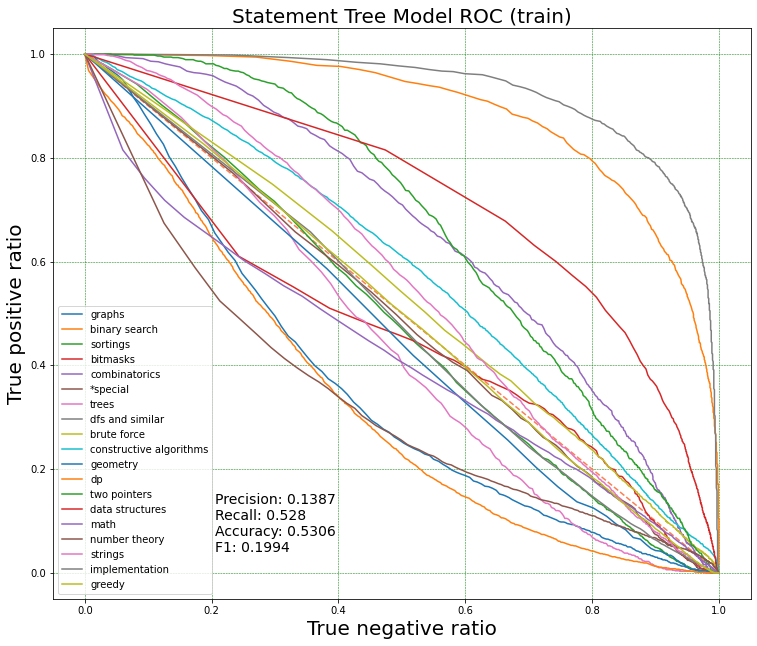

In [12]:
class_thresholds, train_metrics = model.calc_metrics(y_true_train, y_pred_train, plot_name=f'{model.name}_train')

[STM_drop02_conv4n_drop02_dense512_test]
Thresholds:
0.067
0.035
0.020999999999999998
0.005
0.07100000000000001
0.003
0.020999999999999998
0.007
0.003
0.456
0.003
0.304
0.252
0.009000000000000001
0.013000000000000001
0.033
0.245
0.001
0.005

Metrics:
Precision: 0.1403
Recall: 0.5447
Accuracy: 0.533
F1: 0.2019



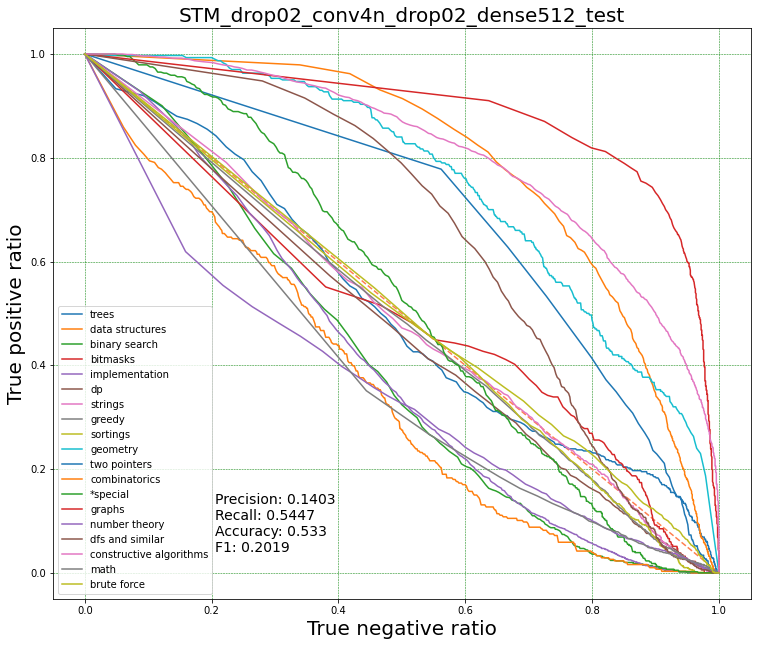

In [53]:
#_, test_metrics = model.calc_metrics(y_true_test, y_pred_test, plot_name=f'{model.name}_test', thresholds=class_thresholds)
_, test_metrics = model.calc_metrics(y_true_test, y_pred_test, plot_name=f'{model.name}_test')

In [47]:
model.fit(epochs=3, batch_size=4)

  0%|          | 0/9101 [00:00<?, ?it/s]

KeyboardInterrupt: 